In [77]:
#라이브러리
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

In [43]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('exchange_rate_20210223.xls.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,Swap Rate -1Y,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,1099.7,0.08063,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.7,0.08013,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.7,0.07813,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.1,NaN,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.5,NaN,0.86,NaN,90.17,0.49,3070.09


In [46]:
#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","SwapRate", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))
df1.head()

,Date,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014.01.02,1055.3,0.0956,2.78,0.0956,80.79,2.51,1967.19
1,2014.01.03,1050.4,0.0950,2.78,0.0950,80.96,2.50,1946.14
2,2014.01.06,1054.1,0.0945,2.77,0.0945,80.81,2.48,1953.28
3,2014.01.07,1062.2,0.0926,2.75,0.0926,80.98,2.50,1959.44
4,2014.01.08,1067.9,0.0925,2.75,0.0925,81.16,2.49,1958.96


In [45]:
#데이터 타입 확인
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1762 non-null   object 
 1   ExchangeRate  1762 non-null   float64
 2   SwapRate      1674 non-null   float64
 3   KORIBOR       1762 non-null   float64
 4   LIBOR         1670 non-null   float64
 5   DollarRate    1755 non-null   float64
 6   CallRate      1762 non-null   float64
 7   KOSPI         1755 non-null   float64
dtypes: float64(7), object(1)
memory usage: 110.2+ KB


In [47]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     0
SwapRate        88
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [48]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

df_intp.tail()

,Date,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.7,0.08063,0.87,0.0815,90.95,0.47,3133.73
1758,2021.02.18,1107.7,0.08013,0.87,0.0815,90.59,0.49,3086.66
1759,2021.02.19,1105.7,0.07813,0.86,0.0815,90.36,0.51,3107.62
1760,2021.02.22,1107.1,0.07813,0.86,0.0815,90.01,0.50,3079.75
1761,2021.02.23,1106.5,0.07813,0.86,0.0815,90.17,0.49,3070.09


In [51]:
df_intp.isna().sum() 
#결측값 보간 확인

Date            0
ExchangeRate    0
SwapRate        0
KORIBOR         0
LIBOR           0
DollarRate      0
CallRate        0
KOSPI           0
dtype: int64

In [55]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

In [61]:
df_intp.head() #기초 완성!

,Date,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,0.0956,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,0.0950,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,0.0945,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,0.0926,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,0.0925,2.75,0.0925,81.16,2.49,1958.96


<AxesSubplot:xlabel='Date'>

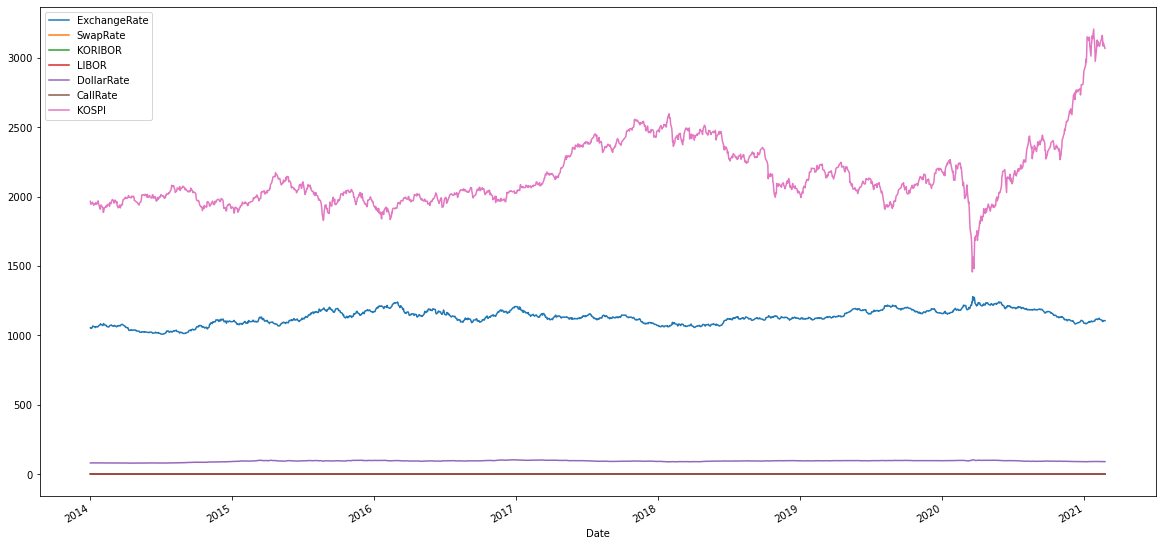

In [63]:
#시각화 해보자
df_intp.plot(x="Date",figsize = (20,10))
#표준화 필수의 느낌이 난다..

## 정상성
- var을 사용하려면 차분을 해줘야한다

In [70]:
df_intp.index = df_intp["Date"]
#df_intp.head() #날짜 열 인덱스로 고정
df_date = df_intp.drop("Date", axis = 1)
df_date.head()

,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,1055.3,0.0956,2.78,0.0956,80.79,2.51,1967.19
2014-01-03,1050.4,0.0950,2.78,0.0950,80.96,2.50,1946.14
2014-01-06,1054.1,0.0945,2.77,0.0945,80.81,2.48,1953.28
2014-01-07,1062.2,0.0926,2.75,0.0926,80.98,2.50,1959.44
2014-01-08,1067.9,0.0925,2.75,0.0925,81.16,2.49,1958.96


In [71]:
#var을 만드려면 데이터가 정상성을 유지하고 있어야한다
#차분 해주자
df_diff = df_date.diff().dropna()
df_diff.head()

,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-03,-4.9,-0.0006,0.00,-0.0006,0.17,-0.01,-21.05
2014-01-06,3.7,-0.0005,-0.01,-0.0005,-0.15,-0.02,7.14
2014-01-07,8.1,-0.0019,-0.02,-0.0019,0.17,0.02,6.16
2014-01-08,5.7,-0.0001,0.00,-0.0001,0.18,-0.01,-0.48
2014-01-09,-1.9,-0.0006,-0.01,-0.0006,-0.02,0.00,-12.85


<AxesSubplot:xlabel='Date'>

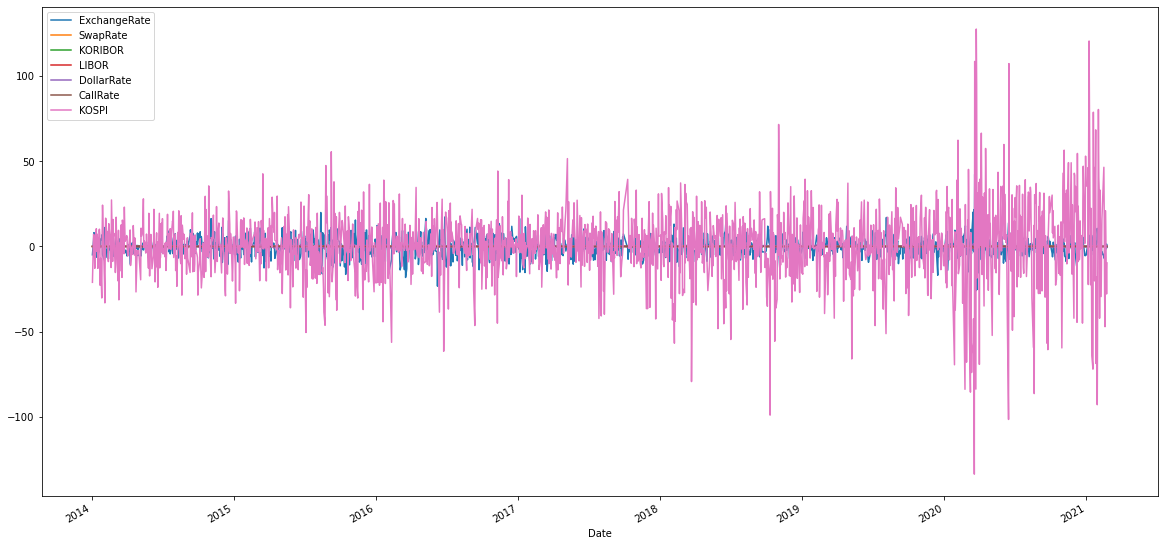

In [72]:
#차분 시각화
df_diff.plot(figsize = (20, 10))

In [73]:
#모델링
#데이터 분할 , 30일 기준으로 해보자
train = df_diff.iloc[:-30,:]
test = df_diff.iloc[-30:,:]

- 최적의 모델을 찾기 위한 기준 AIC(Akaike's Information Criterion)를 모델 선택 기준으로 하자.

In [75]:
#aic 모델은 복잡한 모델은 불이익을 주곤한다.하지만 복잡한 모델일수록 성능이 우수할수 있음
# 그 변곡점을 찾아보자
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
    results = forecasting_model.fit(p)
    results_aic.append(results_aic)

In [1]:
# sns.set()
# plt.plot(list(np.arange(1,10,1)), results_aic)
# plt.xlabel("Order")
# plt.ylabel("AIC")
# plt.show()